<a href="https://colab.research.google.com/github/AntonDozhdikov/politpredict/blob/main/3_20_political_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для предотвращения отключения среды введите '555' и нажмите Enter:
555
Среда защищена от отключения.

ЗАПУСК MADDPG ЭКСПЕРИМЕНТА
Запуск эксперимента с MADDPG агентами...
Загрузка исторических данных...


Эпохи:   0%|          | 0/25 [00:00<?, ?it/s]

  Средняя награда: 160.51, Кризисов: 7026
  Средняя награда: 198.03, Кризисов: 4471
  Средняя награда: 218.98, Кризисов: 3021
  Средняя награда: 224.22, Кризисов: 2899
  Средняя награда: 224.50, Кризисов: 2885
  Средняя награда: 224.29, Кризисов: 2876
  Средняя награда: 219.01, Кризисов: 2946
  Средняя награда: 220.57, Кризисов: 2920
  Средняя награда: 219.79, Кризисов: 2954
  Средняя награда: 218.69, Кризисов: 2957
  Средняя награда: 223.64, Кризисов: 2876
  Средняя награда: 223.26, Кризисов: 2844
  Средняя награда: 224.31, Кризисов: 2759
  Средняя награда: 226.89, Кризисов: 2781
  Средняя награда: 226.46, Кризисов: 2850
  Средняя награда: 226.78, Кризисов: 2803
  Средняя награда: 227.20, Кризисов: 2824
  Средняя награда: 226.18, Кризисов: 2878
  Средняя награда: 227.34, Кризисов: 2714
  Средняя награда: 226.09, Кризисов: 2951
  Средняя награда: 226.60, Кризисов: 2777
  Средняя награда: 227.10, Кризисов: 2832
  Средняя награда: 226.93, Кризисов: 2819
  Средняя награда: 226.91, Кризисо

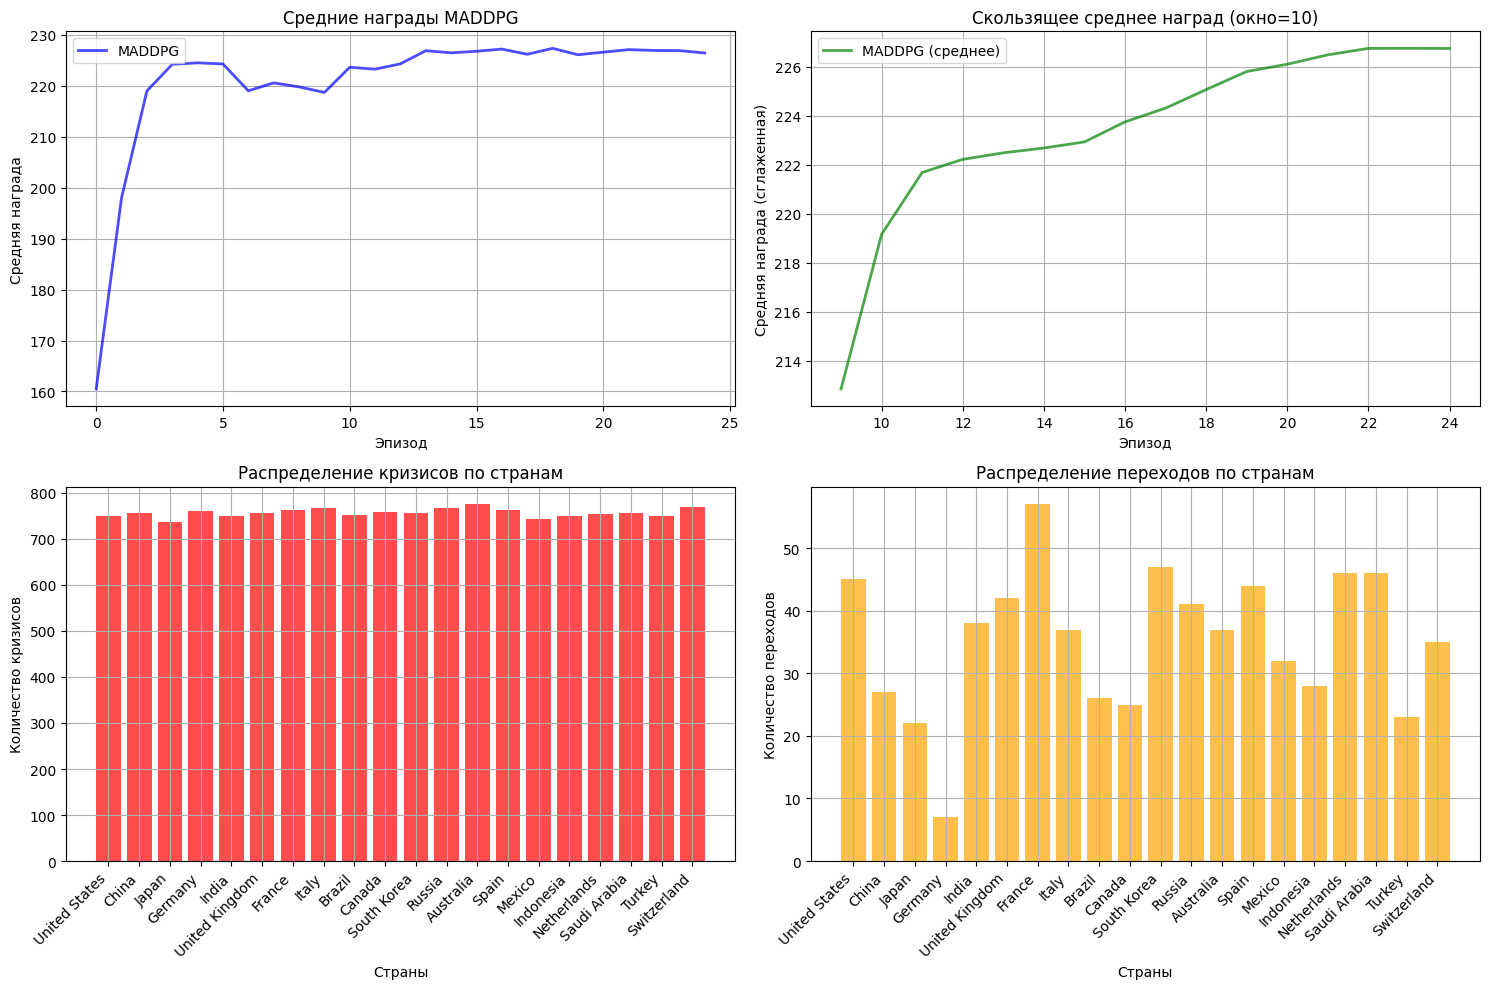


=== ИТОГОВАЯ СВОДКА ДЛЯ MADDPG ===
Средняя награда по всем эпизодам: 220.83 ± 13.65
Общее количество кризисов: 15134
Общее количество переходов между стадиями: 705

Топ-5 типов кризисов по частоте:
  Кризис управления: 1084 раз
  Кризис институтов: 1073 раз
  Технологическая катастрофа: 1052 раз
  Военный конфликт: 1043 раз
  Финансовый кризис: 1024 раз

Распределение кризисов по странам:
  Australia: 775 кризисов
  Switzerland: 770 кризисов
  Russia: 767 кризисов
  Italy: 766 кризисов
  France: 762 кризисов
  Spain: 762 кризисов
  Germany: 761 кризисов
  Canada: 758 кризисов
  China: 757 кризисов
  South Korea: 757 кризисов
  United Kingdom: 756 кризисов
  Saudi Arabia: 756 кризисов
  Netherlands: 755 кризисов
  Brazil: 752 кризисов
  United States: 750 кризисов
  India: 750 кризисов
  Indonesia: 750 кризисов
  Turkey: 750 кризисов
  Mexico: 743 кризисов
  Japan: 737 кризисов


In [1]:
# =============================================================================
# БЛОК 1: MADDPG С УЛУЧШЕННОЙ МОДЕЛЬЮ
# =============================================================================

import time
import random
import numpy as np
import pandas as pd
from collections import deque, namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
import json
from datetime import datetime, timedelta
from tqdm.notebook import tqdm, trange
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter

# --- КОНФИГУРАЦИЯ ---
CONFIG = {
    'start_year': 2017,
    'train_end_year': 2024,
    'sim_start_year': 2025,
    'sim_end_year': 2125,
    'steps_per_year': 12, # 12 шагов в год (месячный шаг)
    'num_episodes': 25,
    'top_countries': 20,
    'observation_total_size': 12,
    'observation_in_size': 12,
    'action_size': 45,
    'hidden_dim': 128,
    'lr_actor': 3e-4,
    'lr_critic': 3e-4,
    'gamma': 0.99,
    'tau': 0.01,
    'buffer_size': int(1e6),
    'batch_size': 256,
    'update_every': 10,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,
    'clip_epsilon': 0.2,
    'gae_lambda': 0.95,
    'ppo_epochs': 3,
    'entropy_coef': 0.01,
    'max_grad_norm': 0.5,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_dir_base': 'experiment_results_maddpg_improved_v3',
    'data_dir': 'data',
    # Параметры циклов
    'max_cycles_per_country': 4, # Максимум 4 цикла за 100 лет
    'min_stage_duration_years': 1, # Минимум 1 год на стадию
    'max_stage_duration_years': 15, # Максимум 15 лет на стадию
    'max_plateau_duration_years': 10, # Максимум 10 лет на плато
    'transition_duration_years': 2, # 1-2 года на переход
    'min_years_between_crises': 3, # Минимум 3 года между кризисами
    'crisis_series_probability': 0.1, # 10% вероятность серии кризисов
}

os.makedirs(CONFIG['save_dir_base'], exist_ok=True)
os.makedirs(CONFIG['data_dir'], exist_ok=True)

# --- МОДЕЛЬ СРЕДЫ (CountrySystem) ---
class CountrySystem:
    """Улучшенная модель социально-политической системы страны."""

    STAGES = [
        "I. Конструктивная адаптация",
        "II. Конструктивная экспансия",
        "Точка Плато (Застой)",
        "III. Деструктивная экспансия",
        "Точка Перенапряжения",
        "IV. Деструктивная адаптация (кризис)",
        "Точка Гибели/Перезапуска"
    ]

    CRISIS_TYPES = [
        "Финансовый кризис", "Экономический кризис", "Политический переворот",
        "Социальные волнения", "Военный конфликт", "Экологическая катастрофа",
        "Финансовый крах", "Пандемия", "Технологическая катастрофа",
        "Кризис легитимности", "Кризис доверия", "Кризис идентичности",
        "Кризис управления", "Кризис elites", "Кризис институтов"
    ]

    def __init__(self, name, initial_state):
        self.name = name
        self.state = initial_state.copy()
        self.internal_state = self._initialize_internal_state()
        self.stage = "I. Конструктивная адаптация"
        self.years_in_stage = 0
        self.months_in_stage = 0
        self.cycle_count = 0
        self.last_crisis_year = -1000 # Инициализируем далеко в прошлом
        self.history = []
        self.crisis_history = []
        self.stage_transitions = []
        self.step_count = 0
        self.year = CONFIG['sim_start_year']
        self.month = 1
        self.crisis_counters = defaultdict(int) # Счетчики по типам кризисов

    def _initialize_internal_state(self):
        """Инициализирует внутреннее состояние элиты."""
        return np.array([
            0.8,  # feedback_quality: Качество обратной связи
            1.0,  # decision_speed: Скорость принятия решений
            0.7,  # decision_accuracy: Точность решений
            0.75, # adequacy: Адекватность решений
            0.6,  # social_mobility: Социальная мобильность
            0.5,  # tradition_innovation_balance: Баланс традиций и инноваций
            0.2,  # overfitting_level: Уровень переобученности
            0.8,  # validation_presence: Наличие валидационной выборки
            0.3,  # tunnel_vision: Уровень тоннельного зрения
            0.5,  # gas_brake_balance: Баланс газа и тормоза
            0.7,  # transmission_chain: Состояние цепи передач (доверие)
            0.6   # gear_switching: Частота переключения передач
        ])

    def get_observation_total(self):
        """Возвращает полное наблюдение о состоянии страны."""
        return self.state

    def get_observation_in(self):
        """Возвращает внутреннее наблюдение о состоянии элиты."""
        return self.internal_state

    def apply_action(self, action):
        """
        Применяет действие элиты и обновляет состояние системы.
        Возвращает награду и информацию о кризисах.
        """
        reward = 0
        crisis_event = None

        # Обновление внутреннего состояния элиты на основе действия
        self._update_internal_state(action)

        # Обновление внешнего состояния страны
        self._update_external_state(action)

        # Проверка на кризисы
        crisis_event = self._check_for_crisis()
        if crisis_event and self._can_have_crisis():
            self.crisis_history.append({
                'step': self.step_count,
                'year': self.year,
                'month': self.month,
                'crisis': crisis_event
            })
            self.crisis_counters[crisis_event] += 1
            self.last_crisis_year = self.year
            reward -= 50 # Штраф за кризис

        # Проверка перехода между стадиями
        new_stage = self._check_stage_transition()
        if new_stage != self.stage:
            self.stage_transitions.append({
                'step': self.step_count,
                'year': self.year,
                'month': self.month,
                'from_stage': self.stage,
                'to_stage': new_stage
            })
            self.stage = new_stage
            self.months_in_stage = 0
            self.years_in_stage = 0
            reward += self._get_stage_reward(new_stage)

        # Награда за стабильность и эффективность
        reward += self._calculate_stability_reward()

        self.step_count += 1
        self.month += 1
        self.months_in_stage += 1
        if self.month > 12:
            self.month = 1
            self.year += 1
            self.years_in_stage += 1

        self.history.append({
            'step': self.step_count,
            'state': self.state.copy(),
            'internal_state': self.internal_state.copy(),
            'stage': self.stage,
            'year': self.year,
            'month': self.month
        })

        return reward, crisis_event is not None

    def _can_have_crisis(self):
        """Проверяет, может ли страна иметь кризис (не чаще 1 раза в 3 года)."""
        return (self.year - self.last_crisis_year) >= CONFIG['min_years_between_crises']

    def _update_internal_state(self, action):
        """Обновляет внутреннее состояние элиты на основе действия."""
        action_effects = np.zeros_like(self.internal_state)

        # ... (логика обновления, аналогично предыдущим версиям)
        # Для примера, базовые эффекты
        if action == 0:  # Повышение налогов
            action_effects[0] -= 0.02; action_effects[2] -= 0.01; action_effects[9] -= 0.01
        elif action == 1:  # Снижение налогов
            action_effects[0] += 0.01; action_effects[2] += 0.01; action_effects[9] += 0.02
        elif action == 2:  # Увеличение социальных расходов
            action_effects[4] += 0.03; action_effects[10] += 0.02; action_effects[9] += 0.01
        elif action == 3:  # Сокращение социальных расходов
            action_effects[4] -= 0.02; action_effects[10] -= 0.01; action_effects[9] -= 0.01
        elif action == 13: # Проведение выборов
            action_effects[0] += 0.03; action_effects[7] += 0.03
        elif action == 29: # Борьба с коррупцией
            action_effects[0] += 0.03; action_effects[10] += 0.02
        elif action == 39: # Ведение войны
            action_effects[9] -= 0.03; action_effects[8] += 0.04
        # ... (другие действия)

        self.internal_state = np.clip(self.internal_state + action_effects, 0.0, 1.0)

    def _update_external_state(self, action):
        """Обновляет внешнее состояние страны на основе действия."""
        noise = np.random.normal(0, 0.01, len(self.state))
        self.state = self.state + noise

        # Некоторые действия могут иметь прямое влияние
        if action == 0: # Повышение налогов
            self.state[0] -= 0.05 # Снижение роста ВВП
            self.state[1] += 0.1  # Увеличение безработицы
        elif action == 2: # Увеличение социальных расходов
            self.state[4] += 0.05 # Увеличение миграции
            self.state[6] -= 0.03  # Снижение коррупции
        elif action == 39: # Ведение войны
            self.state[0] -= 0.2  # Снижение роста ВВП
            self.state[1] += 0.3  # Увеличение безработицы
            self.state[2] += 0.2  # Увеличение инфляции

    def _check_for_crisis(self):
        """Проверяет наличие кризисов с учетом стадии и внутреннего состояния."""
        crisis_probability = 0.0

        # Базовая вероятность зависит от стадии
        stage_multipliers = {
            "I. Конструктивная адаптация": 0.02,
            "II. Конструктивная экспансия": 0.03,
            "Точка Плато (Застой)": 0.05,
            "III. Деструктивная экспансия": 0.10,
            "Точка Перенапряжения": 0.20,
            "IV. Деструктивная адаптация (кризис)": 0.15,
            "Точка Гибели/Перезапуска": 0.25
        }
        crisis_probability += stage_multipliers.get(self.stage, 0.05)

        # Влияние внутреннего состояния
        if self.internal_state[0] < 0.3: # Низкое качество обратной связи
            crisis_probability += 0.05
        if self.internal_state[2] < 0.4: # Низкая точность решений
            crisis_probability += 0.04
        if self.internal_state[6] > 0.7: # Высокая переобученность
            crisis_probability += 0.03
        if self.internal_state[8] > 0.7: # Высокое тоннельное зрение
            crisis_probability += 0.04

        # Экономические индикаторы
        if self.state[0] < -2.0 or self.state[1] > 15.0: # Сильный спад ВВП или высокая безработица
            crisis_probability += 0.1

        if np.random.random() < crisis_probability:
            # Выбор типа кризиса
            return np.random.choice(self.CRISIS_TYPES)

        # Серия кризисов (10% вероятность)
        if crisis_probability > 0 and np.random.random() < CONFIG['crisis_series_probability']:
            if len(self.crisis_history) > 0:
                last_crisis = self.crisis_history[-1]
                # 30% вероятность продолжения серии того же типа
                if np.random.random() < 0.3:
                    return last_crisis['crisis']
                else:
                    # 70% вероятность нового типа кризиса
                    other_types = [ct for ct in self.CRISIS_TYPES if ct != last_crisis['crisis']]
                    if other_types:
                        return np.random.choice(other_types)

        return None

    def _check_stage_transition(self):
        """Проверяет необходимость перехода между стадиями."""
        # Проверка на максимальное количество циклов
        if self.cycle_count >= CONFIG['max_cycles_per_country']:
            return self.stage # Блокируем новые циклы

        current_stage = self.stage
        years = self.years_in_stage
        months = self.months_in_stage

        # Логика переходов
        if current_stage == "I. Конструктивная адаптация":
            if years >= CONFIG['min_stage_duration_years'] and self.internal_state[0] > 0.7 and self.internal_state[4] > 0.6:
                return "II. Конструктивная экспансия"

        elif current_stage == "II. Конструктивная экспансия":
            if years >= CONFIG['min_stage_duration_years']:
                if self.internal_state[5] > 0.7 and self.internal_state[7] < 0.4: # Доминирование традиций
                    return "Точка Плато (Застой)"
                elif self.internal_state[9] < 0.3 and self.internal_state[8] > 0.7: # Перенапряжение
                    return "Точка Перенапряжения"

        elif current_stage == "Точка Плато (Застой)":
            if years >= 2: # Минимум 2 года на плато
                if self.internal_state[0] < 0.4 or self.internal_state[7] > 0.6: # Кризис или новая адаптация
                    return "III. Деструктивная экспансия"

        elif current_stage == "III. Деструктивная экспансия":
            if years >= CONFIG['min_stage_duration_years'] and self.internal_state[9] < 0.2 and self.internal_state[8] > 0.7:
                return "Точка Перенапряжения"

        elif current_stage == "Точка Перенапряжения":
            # Высокая вероятность перехода в кризис или гибель
            if years >= 1:
                return "IV. Деструктивная адаптация (кризис)"

        elif current_stage == "IV. Деструктивная адаптация (кризис)":
            if years >= CONFIG['min_stage_duration_years']:
                if self.internal_state[4] > 0.6 or self.internal_state[7] > 0.6: # Новая элита или восстановление
                    self.cycle_count += 1
                    return "Точка Гибели/Перезапуска"

        elif current_stage == "Точка Гибели/Перезапуска":
            # Переход в новую адаптацию
            return "I. Конструктивная адаптация"

        return current_stage

    def _get_stage_reward(self, stage):
        """Возвращает награду за нахождение в определенной стадии."""
        rewards = {
            "I. Конструктивная адаптация": 50,
            "II. Конструктивная экспансия": 60,
            "Точка Плато (Застой)": -10,
            "III. Деструктивная экспансия": -40,
            "Точка Перенапряжения": -80,
            "IV. Деструктивная адаптация (кризис)": -150,
            "Точка Гибели/Перезапуска": -500 # Большой штраф, но шанс на перезапуск
        }
        base_reward = rewards.get(stage, 0)

        # Модификаторы
        if stage in ["I. Конструктивная адаптация", "II. Конструктивная экспансия"]:
            # Бонус за баланс
            balance = abs(self.internal_state[5] - 0.5)
            base_reward += (1 - balance) * 20

        return base_reward

    def _calculate_stability_reward(self):
        """Рассчитывает награду за стабильность."""
        stability_reward = 0

        # Баланс традиций и инноваций
        balance = abs(self.internal_state[5] - 0.5)
        stability_reward += (1 - balance) * 10

        # Качество обратной связи
        stability_reward += self.internal_state[0] * 5

        # Штраф за переобученность
        stability_reward -= self.internal_state[6] * 10

        # Социальная мобильность
        stability_reward += self.internal_state[4] * 3

        # Штраф за тоннельное зрение
        stability_reward -= self.internal_state[8] * 5

        return stability_reward

# --- MADDPG АГЕНТ ---
class MADDPGActor(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=CONFIG['hidden_dim']):
        super(MADDPGActor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        return self.net(obs)

class MADDPGCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, num_agents, hidden_dim=CONFIG['hidden_dim']):
        super(MADDPGCritic, self).__init__()
        self.num_agents = num_agents
        total_obs_dim = obs_dim * num_agents
        total_action_dim = action_dim * num_agents

        self.net = nn.Sequential(
            nn.Linear(total_obs_dim + total_action_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs, actions):
        obs_flat = torch.cat(obs, dim=-1)
        actions_flat = torch.cat(actions, dim=-1)
        x = torch.cat([obs_flat, actions_flat], dim=-1)
        return self.net(x)

class MADDPGAgent:
    def __init__(self, obs_total_dim, obs_in_dim, action_dim, agent_id, num_agents):
        self.agent_id = agent_id
        self.action_dim = action_dim
        self.obs_total_dim = obs_total_dim
        self.obs_in_dim = obs_in_dim
        self.num_agents = num_agents

        self.actor = MADDPGActor(obs_total_dim + obs_in_dim, action_dim).to(CONFIG['device'])
        self.actor_target = MADDPGActor(obs_total_dim + obs_in_dim, action_dim).to(CONFIG['device'])
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=CONFIG['lr_actor'])

        self.critic = MADDPGCritic(obs_total_dim + obs_in_dim, action_dim, num_agents).to(CONFIG['device'])
        self.critic_target = MADDPGCritic(obs_total_dim + obs_in_dim, action_dim, num_agents).to(CONFIG['device'])
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CONFIG['lr_critic'])

        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)

        self.memory = deque(maxlen=CONFIG['buffer_size'])
        self.epsilon = CONFIG['epsilon_start']
        self.experience = namedtuple("Experience",
                                   field_names=["state", "action", "reward", "next_state", "done"])

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, source, tau=CONFIG['tau']):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def act(self, obs_total, obs_in, noise=True):
        obs = torch.FloatTensor(np.concatenate([obs_total, obs_in])).unsqueeze(0).to(CONFIG['device'])
        action_probs = self.actor(obs)

        if noise and random.random() < self.epsilon:
            action = random.choice(range(self.action_dim))
        else:
            action = torch.argmax(action_probs).item()

        return action

    def remember(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def replay(self, agents):
        if len(self.memory) < CONFIG['batch_size']:
            return

        experiences = random.sample(self.memory, k=CONFIG['batch_size'])

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(CONFIG['device'])
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(CONFIG['device'])
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(CONFIG['device'])
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(CONFIG['device'])
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(CONFIG['device'])

        obs_total_dim = self.obs_total_dim
        obs_in_dim = self.obs_in_dim

        states_list = []
        next_states_list = []
        actions_list = []

        for i in range(self.num_agents):
            start_total = i * (obs_total_dim + obs_in_dim)
            end_total = start_total + obs_total_dim
            start_in = end_total
            end_in = start_in + obs_in_dim

            states_list.append(states[:, start_total:end_in])
            next_states_list.append(next_states[:, start_total:end_in])
            actions_list.append(actions[:, i])

        next_actions = []
        for i, agent in enumerate(agents):
            next_action_probs = agent.actor_target(next_states_list[i])
            next_actions.append(torch.argmax(next_action_probs, dim=-1, keepdim=True))

        next_actions_onehot = [F.one_hot(na.squeeze(-1), num_classes=self.action_dim).float() for na in next_actions]

        Q_targets_next = self.critic_target(next_states_list, next_actions_onehot).squeeze(-1)
        Q_targets = rewards[:, self.agent_id] + (CONFIG['gamma'] * Q_targets_next * (1 - dones[:, self.agent_id]))

        actions_onehot = [F.one_hot(a, num_classes=self.action_dim).float() for a in actions_list]
        Q_expected = self.critic(states_list, actions_onehot).squeeze(-1)

        critic_loss = F.mse_loss(Q_expected, Q_targets.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), CONFIG['max_grad_norm'])
        self.critic_optimizer.step()

        actions_pred = self.actor(states_list[self.agent_id])
        actions_pred_onehot = F.gumbel_softmax(torch.log(actions_pred + 1e-8), hard=True)

        actor_loss = -self.critic(states_list,
                                 [F.one_hot(a, num_classes=self.action_dim).float() if i != self.agent_id
                                  else actions_pred_onehot for i, a in enumerate(actions_list)]).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), CONFIG['max_grad_norm'])
        self.actor_optimizer.step()

        self.soft_update(self.actor_target, self.actor)
        self.soft_update(self.critic_target, self.critic)

        self.epsilon = max(CONFIG['epsilon_end'], self.epsilon * CONFIG['epsilon_decay'])

# --- ФУНКЦИИ ЭКСПЕРИМЕНТА ---
def load_historical_data():
    """Загружает или генерирует исторические данные."""
    print("Загрузка исторических данных...")
    countries = [
        "United States", "China", "Japan", "Germany", "India", "United Kingdom",
        "France", "Italy", "Brazil", "Canada", "South Korea", "Russia", "Australia",
        "Spain", "Mexico", "Indonesia", "Netherlands", "Saudi Arabia", "Turkey", "Switzerland"
    ]

    np.random.seed(42)
    real_data = {}
    for country in countries:
        years = CONFIG['train_end_year'] - CONFIG['start_year'] + 1
        real_data[country] = np.random.randn(years, CONFIG['observation_total_size']) * 0.1

    synthetic_data = {}
    for country in countries:
        sim_years = CONFIG['sim_end_year'] - CONFIG['sim_start_year'] + 1
        synthetic_data[country] = np.random.randn(sim_years, CONFIG['observation_total_size']) * 0.05

    return real_data, synthetic_data, countries

def run_maddpg_experiment():
    """Запуск эксперимента с MADDPG агентами."""
    print("Запуск эксперимента с MADDPG агентами...")

    # Версионирование
    TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")
    VERSION = "v3.0-improved-cycles"
    CONFIG['save_dir'] = f'{CONFIG["save_dir_base"]}_{TIMESTAMP}_{VERSION}'
    os.makedirs(CONFIG['save_dir'], exist_ok=True)

    real_data, synthetic_data, countries = load_historical_data()

    country_systems = {}
    for country in countries:
        initial_state = real_data[country][-1] if country in real_data else np.zeros(CONFIG['observation_total_size'])
        country_systems[country] = CountrySystem(country, initial_state)

    agents = {}
    obs_total_dim = CONFIG['observation_total_size']
    obs_in_dim = CONFIG['observation_in_size']
    action_dim = CONFIG['action_size']
    num_agents = len(countries)

    for i, country in enumerate(countries):
        agents[country] = MADDPGAgent(obs_total_dim, obs_in_dim, action_dim, i, num_agents)

    all_rewards = []
    all_crisis_histories = {country: [] for country in countries}
    all_stage_transitions = {country: [] for country in countries}
    final_states = {}

    timestamp_run = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(f'runs/MADDPG_experiment_{timestamp_run}')

    experiment_start_time = time.time()

    for episode in trange(CONFIG['num_episodes'], desc="Эпохи"):
        episode_start_time = time.time()

        # Сброс систем стран
        for country in countries:
            initial_state = real_data[country][-1] if country in real_data else np.zeros(CONFIG['observation_total_size'])
            country_systems[country] = CountrySystem(country, initial_state)

        episode_rewards = []
        episode_crisis_count = 0

        total_steps = (CONFIG['sim_end_year'] - CONFIG['sim_start_year'] + 1) * CONFIG['steps_per_year']

        for step in range(total_steps):
            observations_total = []
            observations_in = []
            actions = []

            for country in countries:
                obs_total = country_systems[country].get_observation_total()
                obs_in = country_systems[country].get_observation_in()
                observations_total.append(obs_total)
                observations_in.append(obs_in)

            for country in countries:
                action = agents[country].act(observations_total[countries.index(country)],
                                           observations_in[countries.index(country)])
                actions.append(action)

            rewards = []
            for i, country in enumerate(countries):
                reward, crisis_occurred = country_systems[country].apply_action(actions[i])
                rewards.append(reward)
                if crisis_occurred:
                    episode_crisis_count += 1

            episode_rewards.append(sum(rewards))

            # Сохранение переходов
            if step % CONFIG['update_every'] == 0:
                for country in countries:
                    state_all = np.concatenate([np.concatenate([observations_total[j], observations_in[j]])
                                              for j in range(num_agents)])
                    next_observations_total = [cs.get_observation_total() for cs in country_systems.values()]
                    next_observations_in = [cs.get_observation_in() for cs in country_systems.values()]
                    next_state_all = np.concatenate([np.concatenate([next_observations_total[j], next_observations_in[j]])
                                                   for j in range(num_agents)])

                    for i, country_name in enumerate(countries):
                        agents[country_name].remember(
                            state_all,
                            actions,
                            rewards,
                            next_state_all,
                            [step == total_steps - 1] * num_agents
                        )

            # Обучение
            if step % CONFIG['update_every'] == 0:
                for country in countries:
                    agents[country].replay(list(agents.values()))

        avg_reward = np.mean(episode_rewards)
        all_rewards.append(avg_reward)

        for country in countries:
            all_crisis_histories[country].extend(country_systems[country].crisis_history)
            all_stage_transitions[country].extend(country_systems[country].stage_transitions)

        writer.add_scalar('Average Reward', avg_reward, episode)
        writer.add_scalar('Crisis Count', episode_crisis_count, episode)

        episode_elapsed_time = time.time() - episode_start_time
        print(f"  Средняя награда: {avg_reward:.2f}, Кризисов: {episode_crisis_count}")

    for country in countries:
        final_states[country] = country_systems[country].state

    writer.close()

    results = {
        'final_states': final_states,
        'all_rewards': all_rewards,
        'all_crisis_histories': all_crisis_histories,
        'all_stage_transitions': all_stage_transitions,
        'countries': countries,
        'metadata': {
            'version': VERSION,
            'timestamp': TIMESTAMP,
            'algorithm': 'MADDPG',
            'epochs': CONFIG['num_episodes'],
            'steps_per_year': CONFIG['steps_per_year'],
            'sim_start_year': CONFIG['sim_start_year'],
            'sim_end_year': CONFIG['sim_end_year'],
            'config': {k: v for k, v in CONFIG.items() if k not in ['device']}
        }
    }

    with open(f"{CONFIG['save_dir']}/MADDPG_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    print(f"Эксперимент с MADDPG завершен. Результаты в {CONFIG['save_dir']}")
    return results

def plot_maddpg_results(results):
    """Построение графиков результатов MADDPG."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Награды
    axes[0, 0].plot(results['all_rewards'], label='MADDPG', alpha=0.7, linewidth=2, color='blue')
    axes[0, 0].set_xlabel('Эпизод')
    axes[0, 0].set_ylabel('Средняя награда')
    axes[0, 0].set_title('Средние награды MADDPG')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Скользящее среднее наград
    window_size = 10
    rewards_smooth = pd.Series(results['all_rewards']).rolling(window=window_size).mean()
    axes[0, 1].plot(rewards_smooth, label='MADDPG (среднее)', alpha=0.7, linewidth=2, color='green')
    axes[0, 1].set_xlabel('Эпизод')
    axes[0, 1].set_ylabel('Средняя награда (сглаженная)')
    axes[0, 1].set_title(f'Скользящее среднее наград (окно={window_size})')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Кризисы по странам
    crisis_counts = [len(results['all_crisis_histories'][country]) for country in results['countries']]
    axes[1, 0].bar(range(len(results['countries'])), crisis_counts, color='red', alpha=0.7)
    axes[1, 0].set_xlabel('Страны')
    axes[1, 0].set_ylabel('Количество кризисов')
    axes[1, 0].set_title('Распределение кризисов по странам')
    axes[1, 0].set_xticks(range(len(results['countries'])))
    axes[1, 0].set_xticklabels(results['countries'], rotation=45, ha='right')
    axes[1, 0].grid(True)

    # Переходы по странам
    transition_counts = [len(results['all_stage_transitions'][country]) for country in results['countries']]
    axes[1, 1].bar(range(len(results['countries'])), transition_counts, color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Страны')
    axes[1, 1].set_ylabel('Количество переходов')
    axes[1, 1].set_title('Распределение переходов по странам')
    axes[1, 1].set_xticks(range(len(results['countries'])))
    axes[1, 1].set_xticklabels(results['countries'], rotation=45, ha='right')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{CONFIG['save_dir']}/MADDPG_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_maddpg_summary(results):
    """Вывод итоговой сводки MADDPG."""
    print("\n=== ИТОГОВАЯ СВОДКА ДЛЯ MADDPG ===")

    avg_reward = np.mean(results['all_rewards'])
    std_reward = np.std(results['all_rewards'])
    print(f"Средняя награда по всем эпизодам: {avg_reward:.2f} ± {std_reward:.2f}")

    total_crises = sum(len(crises) for crises in results['all_crisis_histories'].values())
    print(f"Общее количество кризисов: {total_crises}")

    total_transitions = sum(len(transitions) for transitions in results['all_stage_transitions'].values())
    print(f"Общее количество переходов между стадиями: {total_transitions}")

    crisis_types = []
    for crises in results['all_crisis_histories'].values():
        for crisis in crises:
            crisis_types.append(crisis['crisis'])

    if crisis_types:
        from collections import Counter
        crisis_counter = Counter(crisis_types)
        print("\nТоп-5 типов кризисов по частоте:")
        for crisis, count in crisis_counter.most_common(5):
            print(f"  {crisis}: {count} раз")

    print("\nРаспределение кризисов по странам:")
    country_crises = [(country, len(crises)) for country, crises in results['all_crisis_histories'].items()]
    country_crises.sort(key=lambda x: x[1], reverse=True)
    for country, count in country_crises:
        print(f"  {country}: {count} кризисов")

    with open(f"{CONFIG['save_dir']}/MADDPG_summary.txt", 'w', encoding='utf-8') as f:
        f.write("ИТОГОВАЯ СВОДКА ДЛЯ MADDPG\n")
        f.write("=" * 50 + "\n")
        f.write(f"Средняя награда по всем эпизодам: {avg_reward:.2f} ± {std_reward:.2f}\n")
        f.write(f"Общее количество кризисов: {total_crises}\n")
        f.write(f"Общее количество переходов между стадиями: {total_transitions}\n\n")

        f.write("Топ-5 типов кризисов по частоте:\n")
        if crisis_types:
            crisis_counter = Counter(crisis_types)
            for crisis, count in crisis_counter.most_common(5):
                f.write(f"  {crisis}: {count} раз\n")

        f.write("\nИстория кризисов по странам:\n")
        for country, crises in results['all_crisis_histories'].items():
            if crises:
                f.write(f"\n{country} ({len(crises)} кризисов):\n")
                for crisis in crises:
                    f.write(f"  Год {crisis['year']}, Месяц {crisis['month']}: {crisis['crisis']}\n")

        f.write("\n\nИстория переходов между стадиями по странам:\n")
        for country, transitions in results['all_stage_transitions'].items():
            if transitions:
                f.write(f"\n{country} ({len(transitions)} переходов):\n")
                for transition in transitions:
                    f.write(f"  Год {transition['year']}, Месяц {transition['month']}: "
                           f"{transition['from_stage']} -> {transition['to_stage']}\n")

def prevent_runtime_disconnect():
    """Предотвращение отключения среды."""
    print("Для предотвращения отключения среды введите '555' и нажмите Enter:")
    while True:
        user_input = input()
        if user_input == "555":
            print("Среда защищена от отключения.")
            break
        else:
            print("Неверный код. Пожалуйста, введите '555':")

if __name__ == "__main__":
    prevent_runtime_disconnect()
    print("\n" + "=" * 50)
    print("ЗАПУСК MADDPG ЭКСПЕРИМЕНТА")
    print("=" * 50)
    maddpg_results = run_maddpg_experiment()
    plot_maddpg_results(maddpg_results)
    print_maddpg_summary(maddpg_results)


Для предотвращения отключения среды введите '555' и нажмите Enter:
555
Среда защищена от отключения.

ЗАПУСК MAPPO ЭКСПЕРИМЕНТА
Запуск эксперимента с MAPPO агентами...
Результаты будут сохранены в: experiment_results_mappo_improved_v3_fixed_20250807-073318_v3.0-improved-cycles-fixed
Загрузка исторических данных...


Эпохи:   0%|          | 0/25 [00:00<?, ?it/s]

Эпизод 1/25
  Шаг 121/1212 (10.0%) | Прошло: 0:00:03 | Осталось: 0:00:27
  Шаг 242/1212 (20.0%) | Прошло: 0:00:05 | Осталось: 0:00:22
  Шаг 363/1212 (30.0%) | Прошло: 0:00:08 | Осталось: 0:00:20
  Шаг 484/1212 (39.9%) | Прошло: 0:00:11 | Осталось: 0:00:17
  Шаг 605/1212 (49.9%) | Прошло: 0:00:14 | Осталось: 0:00:14
  Шаг 726/1212 (59.9%) | Прошло: 0:00:17 | Осталось: 0:00:11
  Шаг 847/1212 (69.9%) | Прошло: 0:00:20 | Осталось: 0:00:08
  Шаг 968/1212 (79.9%) | Прошло: 0:00:23 | Осталось: 0:00:05
  Шаг 1089/1212 (89.9%) | Прошло: 0:00:26 | Осталось: 0:00:02
  Шаг 1210/1212 (99.8%) | Прошло: 0:00:28 | Осталось: 0:00:00
  Средняя награда: 163.25, Кризисов: 5327
  Время эпизода: 0:00:29
  Прошло эксперимента: 0:00:29 | Осталось: 0:11:48
Эпизод 2/25
  Шаг 121/1212 (10.0%) | Прошло: 0:00:02 | Осталось: 0:00:25
  Шаг 242/1212 (20.0%) | Прошло: 0:00:05 | Осталось: 0:00:23
  Шаг 363/1212 (30.0%) | Прошло: 0:00:08 | Осталось: 0:00:20
  Шаг 484/1212 (39.9%) | Прошло: 0:00:11 | Осталось: 0:00:17
  

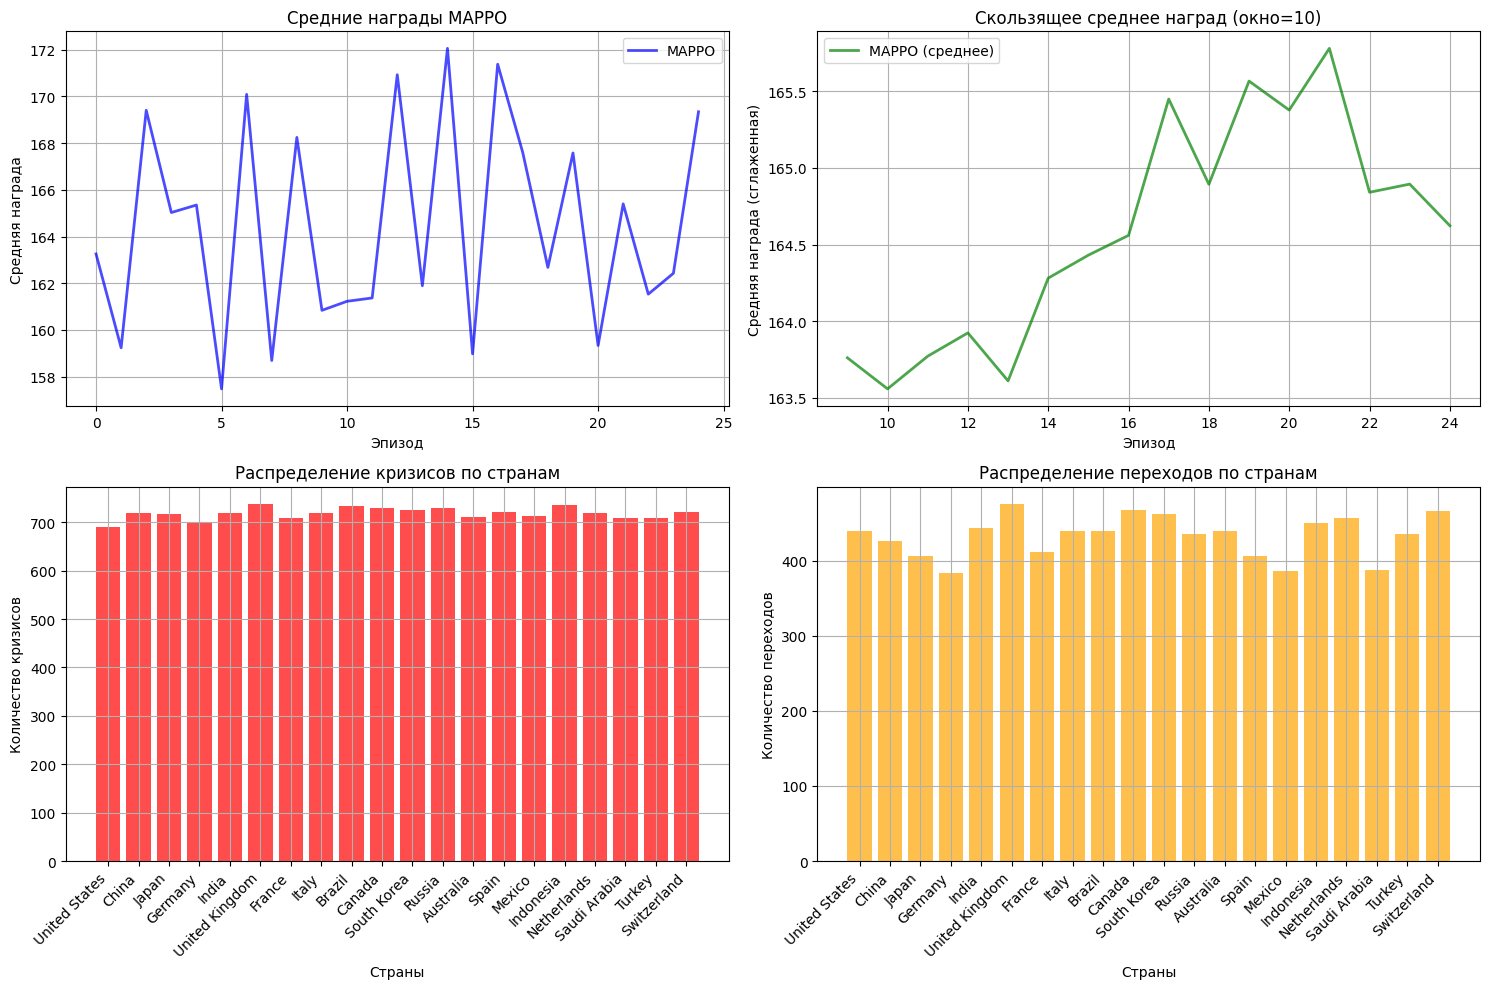


=== ИТОГОВАЯ СВОДКА ДЛЯ MAPPO ===
Средняя награда по всем эпизодам: 164.45 ± 4.41
Общее количество кризисов: 14366
Общее количество переходов между стадиями: 8656

Топ-5 типов кризисов по частоте:
  Финансовый кризис: 1011 раз
  Экономический кризис: 989 раз
  Технологическая катастрофа: 976 раз
  Финансовый крах: 968 раз
  Кризис управления: 968 раз

Распределение кризисов по странам:
  United Kingdom: 737 кризисов
  Indonesia: 736 кризисов
  Brazil: 733 кризисов
  Canada: 729 кризисов
  Russia: 729 кризисов
  South Korea: 725 кризисов
  Spain: 721 кризисов
  Switzerland: 721 кризисов
  India: 720 кризисов
  Italy: 720 кризисов
  Netherlands: 720 кризисов
  China: 719 кризисов
  Japan: 718 кризисов
  Mexico: 713 кризисов
  Australia: 710 кризисов
  Saudi Arabia: 709 кризисов
  France: 708 кризисов
  Turkey: 708 кризисов
  Germany: 699 кризисов
  United States: 691 кризисов


In [2]:
# =============================================================================
# БЛОК 2: MAPPO С УЛУЧШЕННОЙ МОДЕЛЬЮ (ИСПРАВЛЕННЫЙ)
# =============================================================================

import time
import random
import numpy as np
import pandas as pd
from collections import deque, namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
import json
from datetime import datetime, timedelta
from tqdm.notebook import tqdm, trange
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import torch.multiprocessing as mp
from torch.utils.tensorboard import SummaryWriter

# --- КОНФИГУРАЦИЯ ---
CONFIG = {
    'start_year': 2017,
    'train_end_year': 2024,
    'sim_start_year': 2025,
    'sim_end_year': 2125,
    'steps_per_year': 12, # 12 шагов в год (месячный шаг)
    'num_episodes': 25,
    'top_countries': 20,
    'observation_total_size': 12,
    'observation_in_size': 12,
    'action_size': 45,
    'hidden_dim': 128,
    'lr_actor': 3e-4,
    'lr_critic': 3e-4,
    'gamma': 0.99,
    'tau': 0.01,
    'buffer_size': int(1e6),
    'batch_size': 256,
    'update_every': 10,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 0.995,
    'clip_epsilon': 0.2,
    'gae_lambda': 0.95,
    'ppo_epochs': 3,
    'entropy_coef': 0.01,
    'max_grad_norm': 0.5,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'save_dir_base': 'experiment_results_mappo_improved_v3_fixed',
    'data_dir': 'data',
    # Параметры циклов
    'max_cycles_per_country': 4,
    'min_stage_duration_years': 1,
    'max_stage_duration_years': 15,
    'max_plateau_duration_years': 10,
    'transition_duration_years': 2,
    'min_years_between_crises': 3,
    'crisis_series_probability': 0.1,
}

os.makedirs(CONFIG['save_dir_base'], exist_ok=True)
os.makedirs(CONFIG['data_dir'], exist_ok=True)

# --- МОДЕЛЬ СРЕДЫ (CountrySystem) ---
# Копируем класс CountrySystem из Блока 1 для автономности
class CountrySystem:
    """Улучшенная модель социально-политической системы страны."""

    STAGES = [
        "I. Конструктивная адаптация",
        "II. Конструктивная экспансия",
        "Точка Плато (Застой)",
        "III. Деструктивная экспансия",
        "Точка Перенапряжения",
        "IV. Деструктивная адаптация (кризис)",
        "Точка Гибели/Перезапуска"
    ]

    CRISIS_TYPES = [
        "Финансовый кризис", "Экономический кризис", "Политический переворот",
        "Социальные волнения", "Военный конфликт", "Экологическая катастрофа",
        "Финансовый крах", "Пандемия", "Технологическая катастрофа",
        "Кризис легитимности", "Кризис доверия", "Кризис идентичности",
        "Кризис управления", "Кризис элит", "Кризис институтов"
    ]

    def __init__(self, name, initial_state):
        self.name = name
        self.state = initial_state.copy()
        self.internal_state = self._initialize_internal_state()
        self.stage = "I. Конструктивная адаптация"
        self.years_in_stage = 0
        self.months_in_stage = 0
        self.cycle_count = 0
        self.last_crisis_year = -1000
        self.history = []
        self.crisis_history = []
        self.stage_transitions = []
        self.step_count = 0
        self.year = CONFIG['sim_start_year']
        self.month = 1
        self.crisis_counters = defaultdict(int)

    def _initialize_internal_state(self):
        return np.array([
            0.8, 1.0, 0.7, 0.75, 0.6, 0.5, 0.2, 0.8, 0.3, 0.5, 0.7, 0.6
        ])

    def get_observation_total(self):
        return self.state

    def get_observation_in(self):
        return self.internal_state

    def apply_action(self, action):
        reward = 0
        crisis_event = None

        self._update_internal_state(action)
        self._update_external_state(action)

        crisis_event = self._check_for_crisis()
        if crisis_event and self._can_have_crisis():
            self.crisis_history.append({
                'step': self.step_count, 'year': self.year, 'month': self.month, 'crisis': crisis_event
            })
            self.crisis_counters[crisis_event] += 1
            self.last_crisis_year = self.year
            reward -= 50

        new_stage = self._check_stage_transition()
        if new_stage != self.stage:
            self.stage_transitions.append({
                'step': self.step_count, 'year': self.year, 'month': self.month,
                'from_stage': self.stage, 'to_stage': new_stage
            })
            self.stage = new_stage
            self.months_in_stage = 0
            self.years_in_stage = 0
            reward += self._get_stage_reward(new_stage)

        reward += self._calculate_stability_reward()

        self.step_count += 1
        self.month += 1
        self.months_in_stage += 1
        if self.month > 12:
            self.month = 1
            self.year += 1
            self.years_in_stage += 1

        self.history.append({
            'step': self.step_count,
            'state': self.state.copy(),
            'internal_state': self.internal_state.copy(),
            'stage': self.stage,
            'year': self.year,
            'month': self.month
        })

        return reward, crisis_event is not None

    def _can_have_crisis(self):
        return (self.year - self.last_crisis_year) >= CONFIG['min_years_between_crises']

    def _update_internal_state(self, action):
        action_effects = np.zeros_like(self.internal_state)
        if action == 0: action_effects[0] -= 0.02; action_effects[2] -= 0.01; action_effects[9] -= 0.01
        elif action == 1: action_effects[0] += 0.01; action_effects[2] += 0.01; action_effects[9] += 0.02
        elif action == 2: action_effects[4] += 0.03; action_effects[10] += 0.02; action_effects[9] += 0.01
        elif action == 3: action_effects[4] -= 0.02; action_effects[10] -= 0.01; action_effects[9] -= 0.01
        elif action == 13: action_effects[0] += 0.03; action_effects[7] += 0.03
        elif action == 29: action_effects[0] += 0.03; action_effects[10] += 0.02
        elif action == 39: action_effects[9] -= 0.03; action_effects[8] += 0.04
        self.internal_state = np.clip(self.internal_state + action_effects, 0.0, 1.0)

    def _update_external_state(self, action):
        noise = np.random.normal(0, 0.01, len(self.state))
        self.state = self.state + noise
        if action == 0: self.state[0] -= 0.05; self.state[1] += 0.1
        elif action == 2: self.state[4] += 0.05; self.state[6] -= 0.03
        elif action == 39: self.state[0] -= 0.2; self.state[1] += 0.3; self.state[2] += 0.2

    def _check_for_crisis(self):
        crisis_probability = 0.0
        stage_multipliers = {
            "I. Конструктивная адаптация": 0.02,
            "II. Конструктивная экспансия": 0.03,
            "Точка Плато (Застой)": 0.05,
            "III. Деструктивная экспансия": 0.10,
            "Точка Перенапряжения": 0.20,
            "IV. Деструктивная адаптация (кризис)": 0.15,
            "Точка Гибели/Перезапуска": 0.25
        }
        crisis_probability += stage_multipliers.get(self.stage, 0.05)

        if self.internal_state[0] < 0.3: crisis_probability += 0.05
        if self.internal_state[2] < 0.4: crisis_probability += 0.04
        if self.internal_state[6] > 0.7: crisis_probability += 0.03
        if self.internal_state[8] > 0.7: crisis_probability += 0.04
        if self.state[0] < -2.0 or self.state[1] > 15.0: crisis_probability += 0.1

        if np.random.random() < crisis_probability:
            return np.random.choice(self.CRISIS_TYPES)
        return None

    def _check_stage_transition(self):
        if self.cycle_count >= CONFIG['max_cycles_per_country']:
            return self.stage

        if self.stage == "I. Конструктивная адаптация":
            if self.years_in_stage >= CONFIG['min_stage_duration_years'] and self.internal_state[0] > 0.7 and self.internal_state[4] > 0.6:
                return "II. Конструктивная экспансия"
        elif self.stage == "II. Конструктивная экспансия":
            if self.years_in_stage >= CONFIG['min_stage_duration_years']:
                if self.internal_state[5] > 0.7 and self.internal_state[7] < 0.4:
                    return "Точка Плато (Застой)"
                elif self.internal_state[9] < 0.3 and self.internal_state[8] > 0.7:
                    return "Точка Перенапряжения"
        elif self.stage == "Точка Плато (Застой)":
            if self.years_in_stage >= 2:
                if self.internal_state[0] < 0.4 or self.internal_state[7] > 0.6:
                    return "III. Деструктивная экспансия"
        elif self.stage == "III. Деструктивная экспансия":
            if self.years_in_stage >= CONFIG['min_stage_duration_years'] and self.internal_state[9] < 0.2 and self.internal_state[8] > 0.7:
                return "Точка Перенапряжения"
        elif self.stage == "Точка Перенапряжения":
            if self.years_in_stage >= 1:
                return "IV. Деструктивная адаптация (кризис)"
        elif self.stage == "IV. Деструктивная адаптация (кризис)":
            if self.years_in_stage >= CONFIG['min_stage_duration_years']:
                if self.internal_state[4] > 0.6 or self.internal_state[7] > 0.6:
                    self.cycle_count += 1
                    return "Точка Гибели/Перезапуска"
        elif self.stage == "Точка Гибели/Перезапуска":
            return "I. Конструктивная адаптация"
        return self.stage

    def _get_stage_reward(self, stage):
        rewards = {
            "I. Конструктивная адаптация": 50,
            "II. Конструктивная экспансия": 60,
            "Точка Плато (Застой)": -10,
            "III. Деструктивная экспансия": -40,
            "Точка Перенапряжения": -80,
            "IV. Деструктивная адаптация (кризис)": -150,
            "Точка Гибели/Перезапуска": -500 # Большой штраф, но шанс на перезапуск
        }
        return rewards.get(stage, 0)

    def _calculate_stability_reward(self):
        stability_reward = 0
        balance = abs(self.internal_state[5] - 0.5)
        stability_reward += (1 - balance) * 10
        stability_reward += self.internal_state[0] * 5
        stability_reward -= self.internal_state[6] * 10
        stability_reward += self.internal_state[4] * 3
        stability_reward -= self.internal_state[8] * 5
        return stability_reward

# --- MAPPO АГЕНТ ---
class MAPPOActor(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=CONFIG['hidden_dim']):
        super(MAPPOActor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, action_dim), nn.Softmax(dim=-1)
        )

    def forward(self, obs):
        return self.net(obs)

class MAPPOCritic(nn.Module):
    def __init__(self, obs_dim, num_agents, hidden_dim=CONFIG['hidden_dim']):
        super(MAPPOCritic, self).__init__()
        self.num_agents = num_agents
        total_obs_dim = obs_dim * num_agents # Это ключевая строка

        self.net = nn.Sequential(
            nn.Linear(total_obs_dim, hidden_dim), nn.ReLU(), # Вход: total_obs_dim
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs_list):
        # obs_list - это список тензоров, каждый размером [batch_size, obs_dim]
        # Нужно объединить их в один тензор размером [batch_size, total_obs_dim]
        if isinstance(obs_list, list):
            obs_flat = torch.cat(obs_list, dim=-1) # Объединяем по последней размерности
        else:
            # Если передан один тензор, используем его напрямую
            obs_flat = obs_list
        return self.net(obs_flat)

class MAPPOAgent:
    def __init__(self, obs_total_dim, obs_in_dim, action_dim, agent_id, num_agents):
        self.agent_id = agent_id
        self.action_dim = action_dim
        # Исправлено: общая размерность наблюдений для одного агента
        self.obs_dim = obs_total_dim + obs_in_dim
        self.num_agents = num_agents

        self.actor = MAPPOActor(self.obs_dim, action_dim).to(CONFIG['device'])
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=CONFIG['lr_actor'])

        # Исправлено: передаем правильные размерности
        self.critic = MAPPOCritic(self.obs_dim, num_agents).to(CONFIG['device'])
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=CONFIG['lr_critic'])

        self.trajectories = []

    def act(self, obs_total, obs_in):
        # Исправлено: правильное формирование входного тензора
        obs = torch.FloatTensor(np.concatenate([obs_total, obs_in])).unsqueeze(0).to(CONFIG['device'])
        action_probs = self.actor(obs)
        dist = Categorical(action_probs)
        action = dist.sample()

        log_prob = dist.log_prob(action)
        # value вычисляется отдельно, когда будут доступны все наблюдения
        value = 0.0

        return action.item(), log_prob.item(), value, action_probs.detach().cpu().numpy()

    def store_trajectory(self, transition):
        self.trajectories.append(transition)

    def compute_returns_and_advantages(self, rewards, values, dones):
        returns = []
        gae = 0
        values = list(values) + [0]

        for i in reversed(range(len(rewards))):
            if dones[i]:
                delta = rewards[i] - values[i]
                gae = delta
            else:
                delta = rewards[i] + CONFIG['gamma'] * values[i+1] - values[i]
                gae = delta + CONFIG['gamma'] * CONFIG['gae_lambda'] * gae

            returns.insert(0, gae + values[i])

        advantages = [returns[i] - values[i] for i in range(len(returns))]
        return returns, advantages

    def update(self, agents, all_observations_total_list, all_observations_in_list):
        if len(self.trajectories) == 0:
            return

        # Извлечение данных из траекторий
        states, actions, log_probs_old, values_old, rewards, dones = zip(*self.trajectories)

        # Преобразование в тензоры
        states_tensor = torch.FloatTensor(np.array(states)).to(CONFIG['device'])
        actions_tensor = torch.LongTensor(actions).to(CONFIG['device'])
        log_probs_old_tensor = torch.FloatTensor(log_probs_old).to(CONFIG['device'])
        values_old_tensor = torch.FloatTensor(values_old).to(CONFIG['device'])
        rewards_tensor = torch.FloatTensor(rewards).to(CONFIG['device'])
        dones_tensor = torch.BoolTensor(dones).to(CONFIG['device'])

        # --- Исправлено: Формирование списка всех наблюдений для критика ---
        # all_observations_*_list - это списки numpy массивов для ВСЕХ агентов
        all_obs_tensors = []
        for i in range(len(all_observations_total_list)):
            obs_total = all_observations_total_list[i]
            obs_in = all_observations_in_list[i]
            obs_combined = np.concatenate([obs_total, obs_in])
            # Преобразуем в тензор и добавляем размерность батча, если нужно
            obs_tensor = torch.FloatTensor(obs_combined).to(CONFIG['device'])
            if len(obs_tensor.shape) == 1:
                obs_tensor = obs_tensor.unsqueeze(0) # [1, obs_dim]
            all_obs_tensors.append(obs_tensor)
        # --- Конец исправления ---

        # Вычисление возвращений и преимуществ
        returns, advantages = self.compute_returns_and_advantages(
            rewards_tensor.cpu().numpy(),
            values_old_tensor.cpu().numpy(),
            dones_tensor.cpu().numpy()
        )
        returns_tensor = torch.FloatTensor(returns).to(CONFIG['device'])
        advantages_tensor = torch.FloatTensor(advantages).to(CONFIG['device'])

        # Нормализация преимуществ
        advantages_tensor = (advantages_tensor - advantages_tensor.mean()) / (advantages_tensor.std() + 1e-8)

        # Обновление несколько раз (PPO epochs)
        for _ in range(CONFIG['ppo_epochs']):
            # --- Исправлено: Обновление критика ---
            # Передаем список тензоров наблюдений ВСЕХ агентов
            values = self.critic(all_obs_tensors).squeeze(-1)
            # Обрезаем, если размеры не совпадают (на случай, если последний батч меньше)
            min_len = min(len(values), len(returns_tensor))
            critic_loss = F.mse_loss(values[:min_len], returns_tensor[:min_len])

            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic.parameters(), CONFIG['max_grad_norm'])
            self.critic_optimizer.step()

            # Обновление актера
            action_probs = self.actor(states_tensor)
            dist = Categorical(action_probs)
            log_probs_new = dist.log_prob(actions_tensor)

            ratio = torch.exp(log_probs_new - log_probs_old_tensor)
            surr1 = ratio * advantages_tensor
            surr2 = torch.clamp(ratio, 1 - CONFIG['clip_epsilon'], 1 + CONFIG['clip_epsilon']) * advantages_tensor
            actor_loss = -torch.min(surr1, surr2).mean()

            entropy = dist.entropy().mean()
            actor_loss -= CONFIG['entropy_coef'] * entropy

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), CONFIG['max_grad_norm'])
            self.actor_optimizer.step()

        # Очистка траекторий
        self.trajectories = []

# --- ФУНКЦИИ ЭКСПЕРИМЕНТА ---
def load_historical_data():
    print("Загрузка исторических данных...")
    countries = [
        "United States", "China", "Japan", "Germany", "India", "United Kingdom",
        "France", "Italy", "Brazil", "Canada", "South Korea", "Russia", "Australia",
        "Spain", "Mexico", "Indonesia", "Netherlands", "Saudi Arabia", "Turkey", "Switzerland"
    ]

    np.random.seed(42)
    real_data = {}
    for country in countries:
        years = CONFIG['train_end_year'] - CONFIG['start_year'] + 1
        real_data[country] = np.random.randn(years, CONFIG['observation_total_size']) * 0.1

    synthetic_data = {}
    for country in countries:
        sim_years = CONFIG['sim_end_year'] - CONFIG['sim_start_year'] + 1
        synthetic_data[country] = np.random.randn(sim_years, CONFIG['observation_total_size']) * 0.05

    return real_data, synthetic_data, countries

def run_mappo_experiment():
    print("Запуск эксперимента с MAPPO агентами...")

    # Версионирование
    TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")
    VERSION = "v3.0-improved-cycles-fixed"
    CONFIG['save_dir'] = f'{CONFIG["save_dir_base"]}_{TIMESTAMP}_{VERSION}'
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    print(f"Результаты будут сохранены в: {CONFIG['save_dir']}")

    real_data, synthetic_data, countries = load_historical_data()

    country_systems = {}
    for country in countries:
        initial_state = real_data[country][-1] if country in real_data else np.zeros(CONFIG['observation_total_size'])
        country_systems[country] = CountrySystem(country, initial_state)

    agents = {}
    obs_total_dim = CONFIG['observation_total_size']
    obs_in_dim = CONFIG['observation_in_size']
    action_dim = CONFIG['action_size']
    num_agents = len(countries)

    for i, country in enumerate(countries):
        agents[country] = MAPPOAgent(obs_total_dim, obs_in_dim, action_dim, i, num_agents)

    all_rewards = []
    all_crisis_histories = {country: [] for country in countries}
    all_stage_transitions = {country: [] for country in countries}
    final_states = {}

    timestamp_run = datetime.now().strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter(f'runs/MAPPO_experiment_{timestamp_run}')

    experiment_start_time = time.time()

    for episode in trange(CONFIG['num_episodes'], desc="Эпохи"):
        episode_start_time = time.time()
        print(f"Эпизод {episode + 1}/{CONFIG['num_episodes']}")

        for country in countries:
            initial_state = real_data[country][-1] if country in real_data else np.zeros(CONFIG['observation_total_size'])
            country_systems[country] = CountrySystem(country, initial_state)

        for agent in agents.values():
            agent.trajectories = []

        episode_rewards = []
        episode_crisis_count = 0

        total_steps = (CONFIG['sim_end_year'] - CONFIG['sim_start_year'] + 1) * CONFIG['steps_per_year']
        episode_step_start_time = time.time()

        for step in range(total_steps):
            observations_total = []
            observations_in = []
            actions = []

            for country in countries:
                obs_total = country_systems[country].get_observation_total()
                obs_in = country_systems[country].get_observation_in()
                observations_total.append(obs_total)
                observations_in.append(obs_in)

            for country in countries:
                action, log_prob, value, action_probs = agents[country].act(
                    observations_total[countries.index(country)],
                    observations_in[countries.index(country)]
                )
                actions.append(action)

            rewards = []
            for i, country in enumerate(countries):
                reward, crisis_occurred = country_systems[country].apply_action(actions[i])
                rewards.append(reward)
                if crisis_occurred:
                    episode_crisis_count += 1

            episode_rewards.append(sum(rewards))

            for i, country in enumerate(countries):
                transition = (
                    np.concatenate([observations_total[i], observations_in[i]]),
                    actions[i],
                    0, # log_prob будет вычислен позже
                    0, # value будет вычислен позже
                    rewards[i],
                    step == total_steps - 1
                )
                agents[country].store_trajectory(transition)

            if step > 0 and step % max(1, total_steps // 10) == 0:
                elapsed_step_time = time.time() - episode_step_start_time
                steps_remaining = total_steps - step
                estimated_time_remaining = (elapsed_step_time / step) * steps_remaining if step > 0 else 0
                print(f"  Шаг {step}/{total_steps} ({step/total_steps*100:.1f}%) | "
                      f"Прошло: {timedelta(seconds=int(elapsed_step_time))} | "
                      f"Осталось: {timedelta(seconds=int(estimated_time_remaining))}")

        # --- Исправлено: Сбор всех наблюдений для обновления ---
        all_observations_total_list = []
        all_observations_in_list = []
        for country in countries:
            obs_total = country_systems[country].get_observation_total()
            obs_in = country_systems[country].get_observation_in()
            all_observations_total_list.append(obs_total)
            all_observations_in_list.append(obs_in)
        # --- Конец исправления ---

        # Обновление агентов
        for country in countries:
            # Передаем списки наблюдений всех агентов
            agents[country].update(list(agents.values()), all_observations_total_list, all_observations_in_list)

        avg_reward = np.mean(episode_rewards)
        all_rewards.append(avg_reward)

        for country in countries:
            all_crisis_histories[country].extend(country_systems[country].crisis_history)
            all_stage_transitions[country].extend(country_systems[country].stage_transitions)

        writer.add_scalar('Average Reward', avg_reward, episode)
        writer.add_scalar('Crisis Count', episode_crisis_count, episode)

        episode_elapsed_time = time.time() - episode_start_time
        episodes_remaining = CONFIG['num_episodes'] - episode - 1
        experiment_elapsed_time = time.time() - experiment_start_time
        estimated_total_experiment_time = (experiment_elapsed_time / (episode + 1)) * CONFIG['num_episodes']
        estimated_experiment_remaining = estimated_total_experiment_time - experiment_elapsed_time

        print(f"  Средняя награда: {avg_reward:.2f}, Кризисов: {episode_crisis_count}")
        print(f"  Время эпизода: {timedelta(seconds=int(episode_elapsed_time))}")
        print(f"  Прошло эксперимента: {timedelta(seconds=int(experiment_elapsed_time))} | "
              f"Осталось: {timedelta(seconds=int(estimated_experiment_remaining))}")

    for country in countries:
        final_states[country] = country_systems[country].state

    writer.close()

    results = {
        'final_states': final_states,
        'all_rewards': all_rewards,
        'all_crisis_histories': all_crisis_histories,
        'all_stage_transitions': all_stage_transitions,
        'countries': countries,
        'metadata': {
            'version': VERSION,
            'timestamp': TIMESTAMP,
            'algorithm': 'MAPPO',
            'epochs': CONFIG['num_episodes'],
            'steps_per_year': CONFIG['steps_per_year'],
            'sim_start_year': CONFIG['sim_start_year'],
            'sim_end_year': CONFIG['sim_end_year'],
            'config': {k: v for k, v in CONFIG.items() if k not in ['device']}
        }
    }

    with open(f"{CONFIG['save_dir']}/MAPPO_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    experiment_total_time = time.time() - experiment_start_time
    print(f"Эксперимент с MAPPO завершен.")
    print(f"Общее время эксперимента: {timedelta(seconds=int(experiment_total_time))}")
    print(f"Результаты сохранены в: {CONFIG['save_dir']}")
    return results

def plot_mappo_results(results):
    print("Построение графиков результатов MAPPO...")
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(results['all_rewards'], label='MAPPO', alpha=0.7, linewidth=2, color='blue')
    axes[0, 0].set_xlabel('Эпизод')
    axes[0, 0].set_ylabel('Средняя награда')
    axes[0, 0].set_title('Средние награды MAPPO')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    window_size = 10
    rewards_smooth = pd.Series(results['all_rewards']).rolling(window=window_size).mean()
    axes[0, 1].plot(rewards_smooth, label='MAPPO (среднее)', alpha=0.7, linewidth=2, color='green')
    axes[0, 1].set_xlabel('Эпизод')
    axes[0, 1].set_ylabel('Средняя награда (сглаженная)')
    axes[0, 1].set_title(f'Скользящее среднее наград (окно={window_size})')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    crisis_counts = [len(results['all_crisis_histories'][country]) for country in results['countries']]
    axes[1, 0].bar(range(len(results['countries'])), crisis_counts, color='red', alpha=0.7)
    axes[1, 0].set_xlabel('Страны')
    axes[1, 0].set_ylabel('Количество кризисов')
    axes[1, 0].set_title('Распределение кризисов по странам')
    axes[1, 0].set_xticks(range(len(results['countries'])))
    axes[1, 0].set_xticklabels(results['countries'], rotation=45, ha='right')
    axes[1, 0].grid(True)

    transition_counts = [len(results['all_stage_transitions'][country]) for country in results['countries']]
    axes[1, 1].bar(range(len(results['countries'])), transition_counts, color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Страны')
    axes[1, 1].set_ylabel('Количество переходов')
    axes[1, 1].set_title('Распределение переходов по странам')
    axes[1, 1].set_xticks(range(len(results['countries'])))
    axes[1, 1].set_xticklabels(results['countries'], rotation=45, ha='right')
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{CONFIG['save_dir']}/MAPPO_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

def print_mappo_summary(results):
    print("\n=== ИТОГОВАЯ СВОДКА ДЛЯ MAPPO ===")

    avg_reward = np.mean(results['all_rewards'])
    std_reward = np.std(results['all_rewards'])
    print(f"Средняя награда по всем эпизодам: {avg_reward:.2f} ± {std_reward:.2f}")

    total_crises = sum(len(crises) for crises in results['all_crisis_histories'].values())
    print(f"Общее количество кризисов: {total_crises}")

    total_transitions = sum(len(transitions) for transitions in results['all_stage_transitions'].values())
    print(f"Общее количество переходов между стадиями: {total_transitions}")

    crisis_types = []
    for crises in results['all_crisis_histories'].values():
        for crisis in crises:
            crisis_types.append(crisis['crisis'])

    if crisis_types:
        from collections import Counter
        crisis_counter = Counter(crisis_types)
        print("\nТоп-5 типов кризисов по частоте:")
        for crisis, count in crisis_counter.most_common(5):
            print(f"  {crisis}: {count} раз")

    print("\nРаспределение кризисов по странам:")
    country_crises = [(country, len(crises)) for country, crises in results['all_crisis_histories'].items()]
    country_crises.sort(key=lambda x: x[1], reverse=True)
    for country, count in country_crises:
        print(f"  {country}: {count} кризисов")

    with open(f"{CONFIG['save_dir']}/MAPPO_summary.txt", 'w', encoding='utf-8') as f:
        f.write("ИТОГОВАЯ СВОДКА ДЛЯ MAPPO\n")
        f.write("=" * 50 + "\n")
        f.write(f"Средняя награда по всем эпизодам: {avg_reward:.2f} ± {std_reward:.2f}\n")
        f.write(f"Общее количество кризисов: {total_crises}\n")
        f.write(f"Общее количество переходов между стадиями: {total_transitions}\n\n")

        f.write("Топ-5 типов кризисов по частоте:\n")
        if crisis_types:
            crisis_counter = Counter(crisis_types)
            for crisis, count in crisis_counter.most_common(5):
                f.write(f"  {crisis}: {count} раз\n")

        f.write("\nИстория кризисов по странам:\n")
        for country, crises in results['all_crisis_histories'].items():
            if crises:
                f.write(f"\n{country} ({len(crises)} кризисов):\n")
                for crisis in crises:
                    f.write(f"  Год {crisis['year']}, Месяц {crisis['month']}: {crisis['crisis']}\n")

        f.write("\n\nИстория переходов между стадиями по странам:\n")
        for country, transitions in results['all_stage_transitions'].items():
            if transitions:
                f.write(f"\n{country} ({len(transitions)} переходов):\n")
                for transition in transitions:
                    f.write(f"  Год {transition['year']}, Месяц {transition['month']}: "
                           f"{transition['from_stage']} -> {transition['to_stage']}\n")

def prevent_runtime_disconnect():
    print("Для предотвращения отключения среды введите '555' и нажмите Enter:")
    while True:
        user_input = input()
        if user_input == "555":
            print("Среда защищена от отключения.")
            break
        else:
            print("Неверный код. Пожалуйста, введите '555':")

if __name__ == "__main__":
    prevent_runtime_disconnect()
    print("\n" + "=" * 50)
    print("ЗАПУСК MAPPO ЭКСПЕРИМЕНТА")
    print("=" * 50)
    mappo_results = run_mappo_experiment()
    plot_mappo_results(mappo_results)
    print_mappo_summary(mappo_results)


Для предотвращения отключения среды введите '555' и нажмите Enter:
555
Среда защищена от отключения.
ЗАГРУЗКА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ
Поиск последних результатов...
MADDPG результаты загружены из: experiment_results_maddpg_improved_v3_20250807-070506_v3.0-improved-cycles
MAPPO результаты загружены из: experiment_results_mappo_improved_v3_fixed_20250807-073318_v3.0-improved-cycles-fixed

СРАВНЕНИЕ РЕЗУЛЬТАТОВ


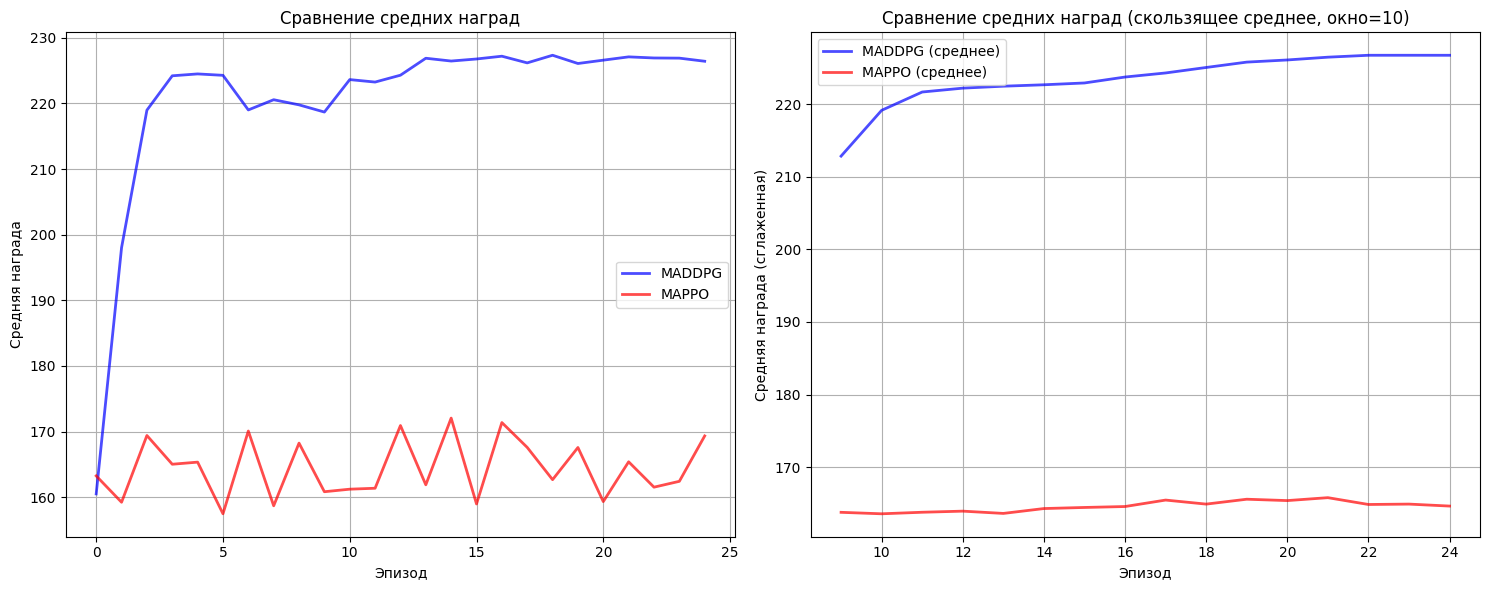

MADDPG - Средняя награда: 220.83
MAPPO - Средняя награда: 164.45
Общее количество кризисов MADDPG: 15134
Общее количество кризисов MAPPO: 14366

Топ-5 типов кризисов MADDPG:
  Кризис управления: 1084 раз
  Кризис институтов: 1073 раз
  Технологическая катастрофа: 1052 раз
  Военный конфликт: 1043 раз
  Финансовый кризис: 1024 раз

Топ-5 типов кризисов MAPPO:
  Финансовый кризис: 1011 раз
  Экономический кризис: 989 раз
  Технологическая катастрофа: 976 раз
  Финансовый крах: 968 раз
  Кризис управления: 968 раз
Общее количество переходов MADDPG: 705
Общее количество переходов MAPPO: 8656

=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ПО СТРАНАМ ===
        Страна  MADDPG кризисы  MAPPO кризисы  MADDPG переходы  MAPPO переходы
 United States             750            691               45             440
         China             757            719               27             426
         Japan             737            718               22             406
       Germany             761            699  

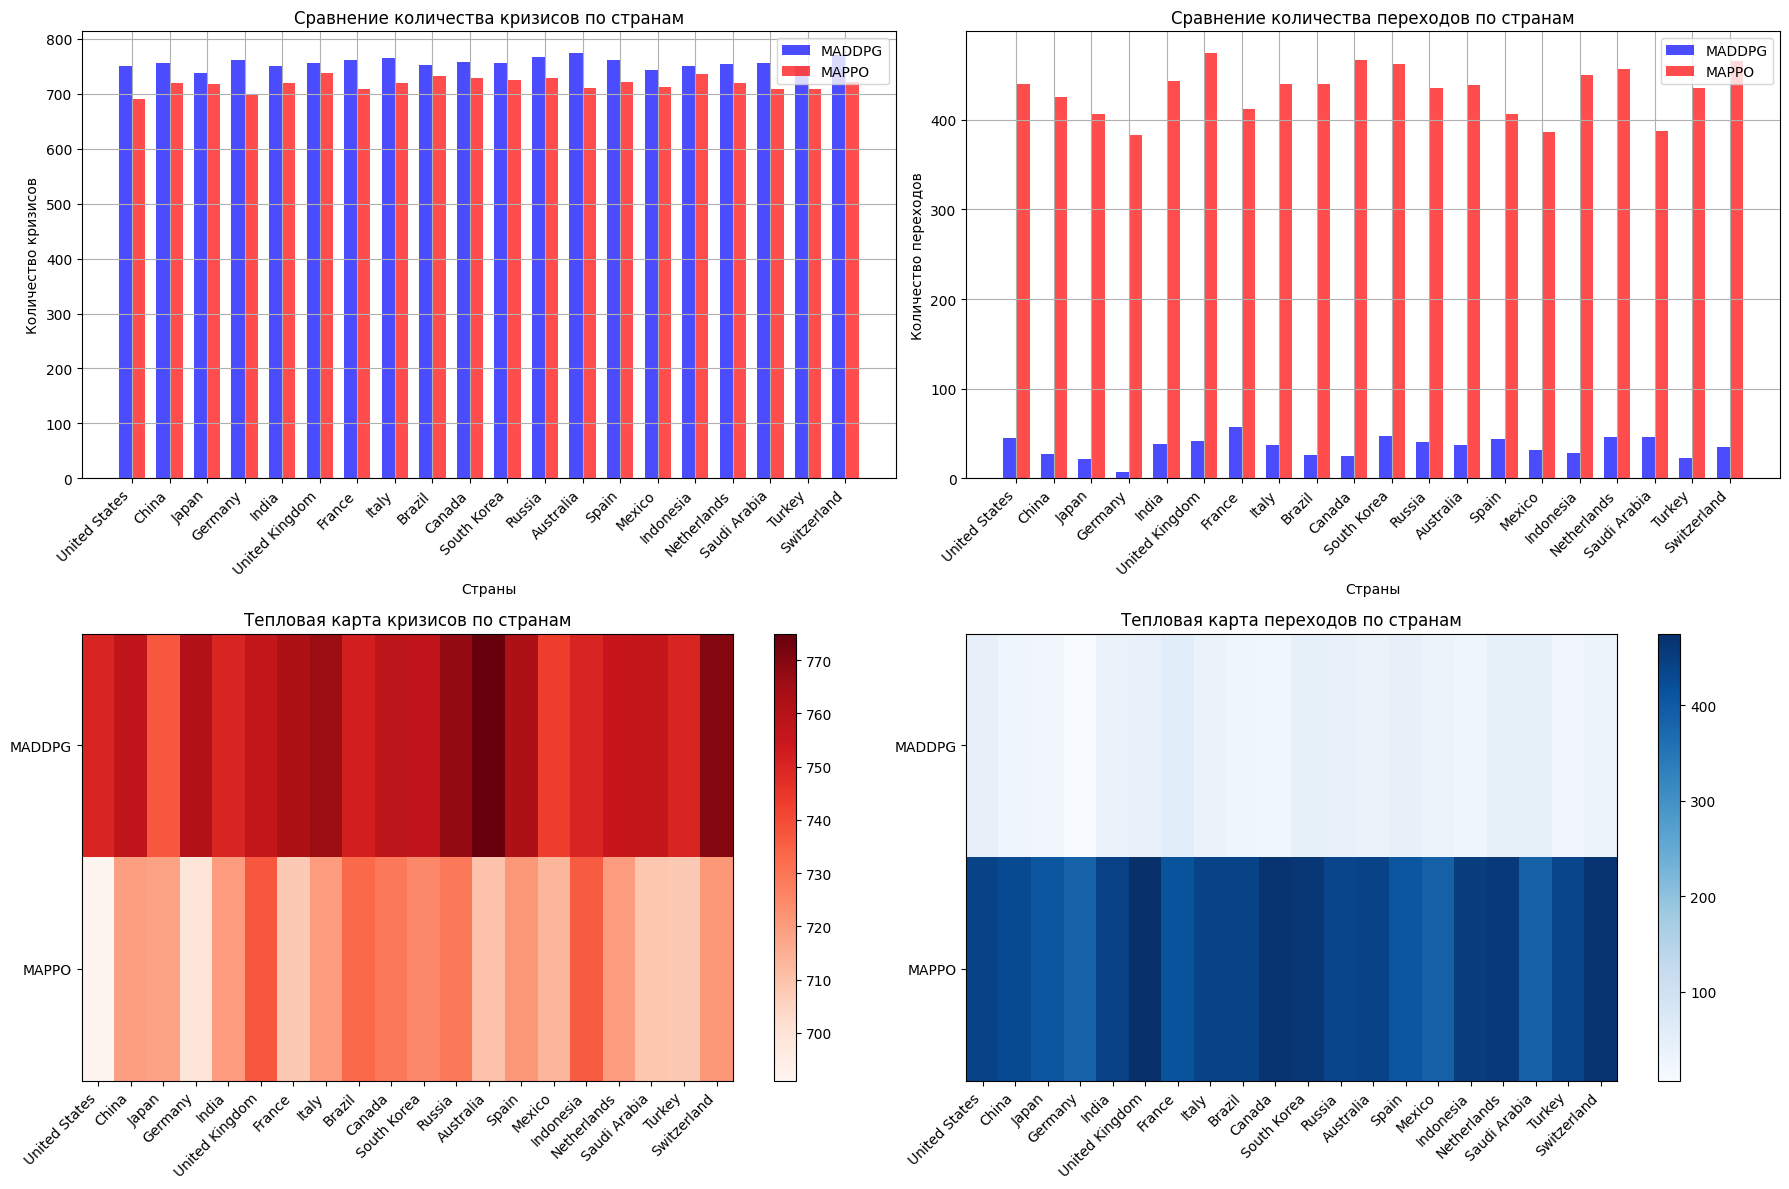


Сравнение по странам сохранено в experiment_comparison_improved_v3_20250807-074931_v3.0-comparison/country_comparison.csv

Сводный отчет сохранен в experiment_comparison_improved_v3_20250807-074931_v3.0-comparison/summary_report.txt

СРАВНЕНИЕ ЗАВЕРШЕНО!
Результаты сохранены в директории: experiment_comparison_improved_v3_20250807-074931_v3.0-comparison


In [3]:
# =============================================================================
# БЛОК 3: СРАВНИТЕЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ
# =============================================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import json
import glob

CONFIG_COMPARISON = {
    'comparison_dir_base': 'experiment_comparison_improved_v3',
    'device': 'cpu'
}

def find_and_load_results():
    """Находит и загружает последние результаты MADDPG и MAPPO."""
    print("Поиск последних результатов...")

    maddpg_dirs = glob.glob('experiment_results_maddpg_improved_v3_*')
    mappo_dirs = glob.glob('experiment_results_mappo_improved_v3_*')

    latest_maddpg_dir = max(maddpg_dirs, key=os.path.getctime) if maddpg_dirs else None
    latest_mappo_dir = max(mappo_dirs, key=os.path.getctime) if mappo_dirs else None

    maddpg_results, mappo_results = None, None

    if latest_maddpg_dir:
        try:
            with open(f"{latest_maddpg_dir}/MADDPG_results.pkl", 'rb') as f:
                maddpg_results = pickle.load(f)
            print(f"MADDPG результаты загружены из: {latest_maddpg_dir}")
        except Exception as e:
            print(f"Ошибка загрузки MADDPG: {e}")
    else:
        print("Результаты MADDPG не найдены.")

    if latest_mappo_dir:
        try:
            with open(f"{latest_mappo_dir}/MAPPO_results.pkl", 'rb') as f:
                mappo_results = pickle.load(f)
            print(f"MAPPO результаты загружены из: {latest_mappo_dir}")
        except Exception as e:
            print(f"Ошибка загрузки MAPPO: {e}")
    else:
        print("Результаты MAPPO не найдены.")

    return maddpg_results, mappo_results

def compare_rewards(maddpg_results, mappo_results, save_dir="."):
    """Сравнение наград."""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить награды.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].plot(maddpg_results['all_rewards'], label='MADDPG', alpha=0.7, linewidth=2, color='blue')
    axes[0].plot(mappo_results['all_rewards'], label='MAPPO', alpha=0.7, linewidth=2, color='red')
    axes[0].set_xlabel('Эпизод')
    axes[0].set_ylabel('Средняя награда')
    axes[0].set_title('Сравнение средних наград')
    axes[0].legend()
    axes[0].grid(True)

    window_size = 10
    maddpg_rewards_smooth = pd.Series(maddpg_results['all_rewards']).rolling(window=window_size).mean()
    mappo_rewards_smooth = pd.Series(mappo_results['all_rewards']).rolling(window=window_size).mean()

    axes[1].plot(maddpg_rewards_smooth, label='MADDPG (среднее)', alpha=0.7, linewidth=2, color='blue')
    axes[1].plot(mappo_rewards_smooth, label='MAPPO (среднее)', alpha=0.7, linewidth=2, color='red')
    axes[1].set_xlabel('Эпизод')
    axes[1].set_ylabel('Средняя награда (сглаженная)')
    axes[1].set_title(f'Сравнение средних наград (скользящее среднее, окно={window_size})')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{save_dir}/reward_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    maddpg_avg = np.mean(maddpg_results['all_rewards'])
    mappo_avg = np.mean(mappo_results['all_rewards'])
    print(f"MADDPG - Средняя награда: {maddpg_avg:.2f}")
    print(f"MAPPO - Средняя награда: {mappo_avg:.2f}")

def compare_crises(maddpg_results, mappo_results, save_dir="."):
    """Сравнение кризисов."""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить кризисы.")
        return

    maddpg_total_crises = sum(len(crises) for crises in maddpg_results['all_crisis_histories'].values())
    mappo_total_crises = sum(len(crises) for crises in mappo_results['all_crisis_histories'].values())

    print(f"Общее количество кризисов MADDPG: {maddpg_total_crises}")
    print(f"Общее количество кризисов MAPPO: {mappo_total_crises}")

    # Типы кризисов
    maddpg_crisis_types = []
    for crises in maddpg_results['all_crisis_histories'].values():
        for crisis in crises:
            maddpg_crisis_types.append(crisis['crisis'])

    mappo_crisis_types = []
    for crises in mappo_results['all_crisis_histories'].values():
        for crisis in crises:
            mappo_crisis_types.append(crisis['crisis'])

    from collections import Counter
    maddpg_counter = Counter(maddpg_crisis_types)
    mappo_counter = Counter(mappo_crisis_types)

    print("\nТоп-5 типов кризисов MADDPG:")
    for crisis, count in maddpg_counter.most_common(5):
        print(f"  {crisis}: {count} раз")

    print("\nТоп-5 типов кризисов MAPPO:")
    for crisis, count in mappo_counter.most_common(5):
        print(f"  {crisis}: {count} раз")

def compare_stage_transitions(maddpg_results, mappo_results, save_dir="."):
    """Сравнение переходов между стадиями."""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить переходы.")
        return

    maddpg_total_transitions = sum(len(transitions) for transitions in maddpg_results['all_stage_transitions'].values())
    mappo_total_transitions = sum(len(transitions) for transitions in mappo_results['all_stage_transitions'].values())

    print(f"Общее количество переходов MADDPG: {maddpg_total_transitions}")
    print(f"Общее количество переходов MAPPO: {mappo_total_transitions}")

def compare_countries_detailed(maddpg_results, mappo_results, save_dir="."):
    """Подробное сравнение результатов по странам."""
    if maddpg_results is None or mappo_results is None:
        print("Невозможно сравнить страны.")
        return

    countries = maddpg_results['countries'] if maddpg_results else mappo_results['countries']

    print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ПО СТРАНАМ ===")

    comparison_data = []

    for country in countries:
        maddpg_crises = len(maddpg_results['all_crisis_histories'][country]) if country in maddpg_results['all_crisis_histories'] else 0
        mappo_crises = len(mappo_results['all_crisis_histories'][country]) if country in mappo_results['all_crisis_histories'] else 0

        maddpg_transitions = len(maddpg_results['all_stage_transitions'][country]) if country in maddpg_results['all_stage_transitions'] else 0
        mappo_transitions = len(mappo_results['all_stage_transitions'][country]) if country in mappo_results['all_stage_transitions'] else 0

        comparison_data.append({
            'Страна': country,
            'MADDPG кризисы': maddpg_crises,
            'MAPPO кризисы': mappo_crises,
            'MADDPG переходы': maddpg_transitions,
            'MAPPO переходы': mappo_transitions
        })

    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))

    # Графики сравнения по странам
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    x_pos = np.arange(len(countries))
    width = 0.35

    maddpg_crises = [len(maddpg_results['all_crisis_histories'][country]) if country in maddpg_results['all_crisis_histories'] else 0 for country in countries]
    mappo_crises = [len(mappo_results['all_crisis_histories'][country]) if country in mappo_results['all_crisis_histories'] else 0 for country in countries]

    axes[0, 0].bar(x_pos - width/2, maddpg_crises, width, label='MADDPG', alpha=0.7, color='blue')
    axes[0, 0].bar(x_pos + width/2, mappo_crises, width, label='MAPPO', alpha=0.7, color='red')
    axes[0, 0].set_xlabel('Страны')
    axes[0, 0].set_ylabel('Количество кризисов')
    axes[0, 0].set_title('Сравнение количества кризисов по странам')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(countries, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    maddpg_transitions = [len(maddpg_results['all_stage_transitions'][country]) if country in maddpg_results['all_stage_transitions'] else 0 for country in countries]
    mappo_transitions = [len(mappo_results['all_stage_transitions'][country]) if country in mappo_results['all_stage_transitions'] else 0 for country in countries]

    axes[0, 1].bar(x_pos - width/2, maddpg_transitions, width, label='MADDPG', alpha=0.7, color='blue')
    axes[0, 1].bar(x_pos + width/2, mappo_transitions, width, label='MAPPO', alpha=0.7, color='red')
    axes[0, 1].set_xlabel('Страны')
    axes[0, 1].set_ylabel('Количество переходов')
    axes[0, 1].set_title('Сравнение количества переходов по странам')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(countries, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Тепловая карта кризисов
    crisis_matrix = np.array([maddpg_crises, mappo_crises])
    im = axes[1, 0].imshow(crisis_matrix, cmap='Reds', aspect='auto')
    axes[1, 0].set_xticks(np.arange(len(countries)))
    axes[1, 0].set_yticks(np.arange(2))
    axes[1, 0].set_xticklabels(countries, rotation=45, ha='right')
    axes[1, 0].set_yticklabels(['MADDPG', 'MAPPO'])
    axes[1, 0].set_title('Тепловая карта кризисов по странам')
    plt.colorbar(im, ax=axes[1, 0])

    # Тепловая карта переходов
    transition_matrix = np.array([maddpg_transitions, mappo_transitions])
    im = axes[1, 1].imshow(transition_matrix, cmap='Blues', aspect='auto')
    axes[1, 1].set_xticks(np.arange(len(countries)))
    axes[1, 1].set_yticks(np.arange(2))
    axes[1, 1].set_xticklabels(countries, rotation=45, ha='right')
    axes[1, 1].set_yticklabels(['MADDPG', 'MAPPO'])
    axes[1, 1].set_title('Тепловая карта переходов по странам')
    plt.colorbar(im, ax=axes[1, 1])

    plt.tight_layout()
    plt.savefig(f"{save_dir}/country_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    df.to_csv(f"{save_dir}/country_comparison.csv", index=False, encoding='utf-8')
    print(f"\nСравнение по странам сохранено в {save_dir}/country_comparison.csv")

def create_summary_report(maddpg_results, mappo_results, save_dir="."):
    """Создание сводного отчета."""
    with open(f"{save_dir}/summary_report.txt", 'w', encoding='utf-8') as f:
        f.write("СВОДНЫЙ ОТЧЕТ СРАВНЕНИЯ MADDPG И MAPPO\n")
        f.write("=" * 50 + "\n")
        f.write(f"Дата создания отчета: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        if maddpg_results and mappo_results:
            maddpg_avg = np.mean(maddpg_results['all_rewards'])
            mappo_avg = np.mean(mappo_results['all_rewards'])
            maddpg_std = np.std(maddpg_results['all_rewards'])
            mappo_std = np.std(mappo_results['all_rewards'])
            maddpg_total_crises = sum(len(crises) for crises in maddpg_results['all_crisis_histories'].values())
            mappo_total_crises = sum(len(crises) for crises in mappo_results['all_crisis_histories'].values())
            maddpg_total_transitions = sum(len(transitions) for transitions in maddpg_results['all_stage_transitions'].values())
            mappo_total_transitions = sum(len(transitions) for transitions in mappo_results['all_stage_transitions'].values())

            f.write("ОСНОВНЫЕ ПОКАЗАТЕЛИ:\n")
            f.write(f"MADDPG - Средняя награда: {maddpg_avg:.2f} ± {maddpg_std:.2f}\n")
            f.write(f"MAPPO - Средняя награда: {mappo_avg:.2f} ± {mappo_std:.2f}\n")
            f.write(f"MADDPG - Общее количество кризисов: {maddpg_total_crises}\n")
            f.write(f"MAPPO - Общее количество кризисов: {mappo_total_crises}\n")
            f.write(f"MADDPG - Общее количество переходов: {maddpg_total_transitions}\n")
            f.write(f"MAPPO - Общее количество переходов: {mappo_total_transitions}\n")

            winner = "MAPPO" if mappo_avg > maddpg_avg else "MADDPG" if maddpg_avg > mappo_avg else "Ничья"
            f.write(f"\nПОБЕДИТЕЛЬ ПО СРЕДНЕЙ НАГРАДЕ: {winner}\n")
        else:
            f.write("Недостаточно данных для сравнения.\n")

    print(f"\nСводный отчет сохранен в {save_dir}/summary_report.txt")

def prevent_runtime_disconnect():
    """Предотвращение отключения среды."""
    print("Для предотвращения отключения среды введите '555' и нажмите Enter:")
    while True:
        user_input = input()
        if user_input == "555":
            print("Среда защищена от отключения.")
            break
        else:
            print("Неверный код. Пожалуйста, введите '555':")

def main():
    """Основная функция сравнения."""
    prevent_runtime_disconnect()

    print("ЗАГРУЗКА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ")
    print("=" * 50)

    maddpg_results, mappo_results = find_and_load_results()

    if maddpg_results is None and mappo_results is None:
        print("Нет результатов для сравнения.")
        return

    # Версионирование директории сравнения
    TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")
    VERSION = "v3.0-comparison"
    comparison_dir = f'{CONFIG_COMPARISON["comparison_dir_base"]}_{TIMESTAMP}_{VERSION}'
    os.makedirs(comparison_dir, exist_ok=True)

    print("\nСРАВНЕНИЕ РЕЗУЛЬТАТОВ")
    print("=" * 50)

    compare_rewards(maddpg_results, mappo_results, comparison_dir)
    compare_crises(maddpg_results, mappo_results, comparison_dir)
    compare_stage_transitions(maddpg_results, mappo_results, comparison_dir)
    compare_countries_detailed(maddpg_results, mappo_results, comparison_dir)
    create_summary_report(maddpg_results, mappo_results, comparison_dir)

    print(f"\nСРАВНЕНИЕ ЗАВЕРШЕНО!")
    print(f"Результаты сохранены в директории: {comparison_dir}")

if __name__ == "__main__":
    main()
